## Hyper-Parameter Optimization with PCA

1) Combine PCA with data scaling
2) Compute and visualize PC components
3) Select the number of PCs with K-fold cross validation
4) Implement the multi-stage classifier pipeline in sklearn
5) Perform automatic parameter search using GridSearchCV in combination with a pipeline

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [4]:
#download the data
data = load_wine()

feat_names = data.feature_names 
tar_names = data.target_names
print(f'Features names = \n{feat_names}\n')
print(f'Target names = \n{tar_names}')

Features names = 
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']

Target names = 
['class_0' 'class_1' 'class_2']


In [12]:
# the number of samples and number of features and number of classes
X = data.data
y = data.target

print(f'Number of samples = {X.shape[0]} \nNumber of features = {len(feat_names)}')
print(f'Number of classes = {len(tar_names)}')

Number of samples = 178 
Number of features = 13
Number of classes = 3


#### Perform PCA for Visualization

Scale the data matrix to remove the mean and normalize the variance of the different components.  
-Create a StandardScaling object scaling
-Fit the scaling with the entire data X 
-Transform the data and let Xs be the scaled data.

In [23]:
from sklearn.preprocessing import StandardScaler

scaling = StandardScaler()
scaling.fit(X)
Xs = scaling.transform(X)

In [116]:
#Fit a PCA on the scaled data matrix Xs
ncomp = 2
pca = PCA(n_components=ncomp, svd_solver='randomized', whiten=True)
pca.fit(Xs)
Z = pca.transform(Xs)

# In the transformed basis, each data sample is represented by a two dimensional vector, Z[i,0], Z[i,1]

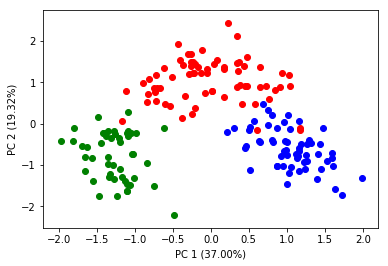

In [138]:
for idx in range (len(y)):
    if y[idx]==0:
        plt.scatter(Z[idx,0], Z[idx,1],color='blue')
    if y[idx]==1:
        plt.scatter(Z[idx,0], Z[idx,1],color='red')
    if y[idx]==2:
        plt.scatter(Z[idx,0], Z[idx,1],color='green')


plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.show()

Refit the scaled data Xs using n_components=nfeatures where nfeatures is the number of features (maximum number of PCs). Get the singular values from pca.singular_values_ and plot the portion of variation as a function of the number of PCs. The PoV for using n PCs is:

PoV[n]  = \sum_{i=0}^{n-1}  s[i]**2 / \sum_{i=0}^{d-1}  s[i]**2

where s[i] is the i-th singular value and d is the number of features. You should see that the 4 PCs contains more than 70% of the variance.

At PC=4, PoV reaches 73.599%


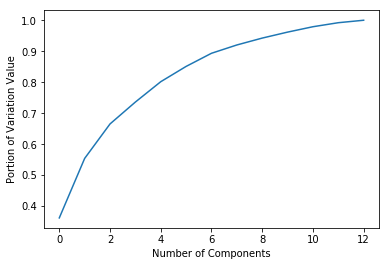

In [78]:
ncomp = len(feat_names)
pca = PCA(n_components=ncomp, svd_solver='randomized', whiten=True)
pca.fit(Xs)

s_vals = pca.singular_values_
s=s_vals[0:ncomp]
S = np.diag(s)
lam = S**2

#PoV = np.cumsum(lam)/np.sum(lam)
PoV = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(0,ncomp), PoV)
plt.xlabel('Number of Components')
plt.ylabel('Portion of Variation Value')

print(f'At PC=4, PoV reaches {np.around(PoV[3]*100, 3)}%')

#### Using PCA with Classification

Use data scaling and PCA as a pre-processing step for logistic classification. The number of PCs to use can be found with cross-validation

In [166]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
nfold = 5

# Create a K-fold object
kf = KFold(n_splits=nfold)
kf.get_n_splits(X)

# Number of PCs to try
ncomp_test = np.arange(2,12)
num_nc = len(ncomp_test)

# Accuracy:  acc[icomp,ifold]  is test accuracy when using `ncomp = ncomp_test[icomp]` in fold `ifold`.
acc = np.zeros((num_nc,nfold))

# Loop over number of components to test
for icomp, ncomp in enumerate(ncomp_test):
    
    # Look over the folds
    for ifold, I in enumerate(kf.split(X)):
        Itr, Its = I

        # Split data into training 
        Xtr, Xts, ytr, yts = X[Itr], X[Its], y[Itr], y[Its]

        # Create a scaling object and fit the scaling on the training data
        scaling = StandardScaler()
        scaling.fit(Xtr)
        Xtr_s = scaling.transform(Xtr)

        # Fit the PCA on the scaled training data
        pca = PCA(n_components=ncomp, svd_solver='randomized', whiten=True)
        pca.fit(Xtr_s)

        # Train a classifier on the transformed training data
        Ztr = pca.transform(Xtr_s)
        # Use a logistic regression classifier
        logreg = LogisticRegression(multi_class='auto', solver='lbfgs')
        logreg.fit(Ztr, ytr)
        # Transform the test data through data scaler and PCA
        Xts_s = scaling.transform(Xts)
        Zts = pca.transform(Xts_s)
        
        # Predict the labels the test data
        yhat = logreg.predict(Zts)
        # TODO:  Measure the accuracy 
        acc[icomp, ifold] = np.mean(yhat == yts)
        print(f'Number of componenets = {icomp}, kfold = {ifold}, accuracy = {acc[icomp, ifold]}')

Number of componenets = 0, kfold = 0, accuracy = 0.9166666666666666
Number of componenets = 0, kfold = 1, accuracy = 0.9444444444444444
Number of componenets = 0, kfold = 2, accuracy = 0.8888888888888888
Number of componenets = 0, kfold = 3, accuracy = 0.9142857142857143
Number of componenets = 0, kfold = 4, accuracy = 0.9714285714285714
Number of componenets = 1, kfold = 0, accuracy = 0.8611111111111112
Number of componenets = 1, kfold = 1, accuracy = 0.9444444444444444
Number of componenets = 1, kfold = 2, accuracy = 0.8888888888888888
Number of componenets = 1, kfold = 3, accuracy = 0.9428571428571428
Number of componenets = 1, kfold = 4, accuracy = 0.9714285714285714
Number of componenets = 2, kfold = 0, accuracy = 0.8611111111111112
Number of componenets = 2, kfold = 1, accuracy = 0.9722222222222222
Number of componenets = 2, kfold = 2, accuracy = 0.8888888888888888
Number of componenets = 2, kfold = 3, accuracy = 0.9714285714285714
Number of componenets = 2, kfold = 4, accuracy =

Find the optimal number of PCs to use according to the normal rule and one SE rule

Optimal order with the normal rule = 11
Optimal order with one SE rule = 2


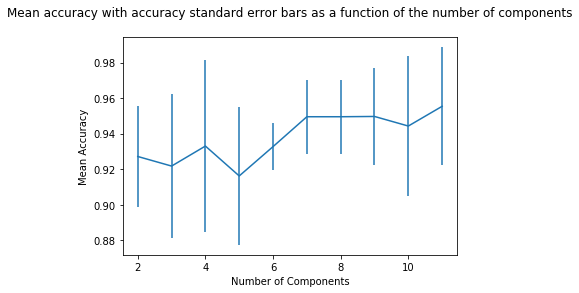

In [206]:
from scipy import stats

acc_mean = np.mean(acc, axis = 1)
acc_se = np.std(acc, axis=1)

plt.errorbar(ncomp_test, acc_mean, yerr = acc_se)
plt.xlabel('Number of Components')
plt.ylabel('Mean Accuracy')
plt.title('Mean accuracy with accuracy standard error bars as a function of the number of components\n')

#Optimal order with the normal rule
idx_n = np.argmax(acc_mean)
print(f'Optimal order with the normal rule = {ncomp_test[idx_n]}')

#Optimal order with one SE rule
acc_tar = acc_mean[idx_n]-acc_se[idx_n]
idx_se = np.where(acc_mean>acc_tar)[0][0]

print(f'Optimal order with one SE rule = {ncomp_test[idx_se]}')

#### Hyper-Parameter Optimization with GridCV

Support vector classifier with a radial basis function. 

An estimator pipeline i followed by an estimator that will operate on the transformed data will be used:
*Create a StandardScaler() object called scaler for the first transformation
*Create a PCA() object called pca for the second transformation
*Create a SVC() object called svc for the final SVM classifier. Set the parameter kernel='rbf'.

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', svc)])

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

scaler = StandardScaler()
pca = PCA()
svc = SVC(kernel='rbf')
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', svc)])

In [106]:
ncomp_test = np.arange(3,10)
c_test = np.logspace(-2,3,6)
gam_test = np.logspace(-3,1,5)

In [139]:
params = {'pca__n_components': ncomp_test, 'svc__C' : c_test, 'svc__gamma' : gam_test}

In [140]:
estimator = GridSearchCV(estimator=pipe, param_grid=params, cv=5, return_train_score=True, iid=False)
estimator.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'pca__n_components': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 'svc__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [143]:
print(f'Estimator best test score =  {np.around(estimator.best_score_,3)}')
print(f'Estimator best parameters:\n{estimator.best_params_}')

Estimator best test score =  0.983
Estimator best parameters:
{'pca__n_components': 11, 'svc__C': 10.0, 'svc__gamma': 0.01}


[10, 6, 5]


Text(0.5, 1.0, 'Mean test score over gamma and C for the value 5 components')

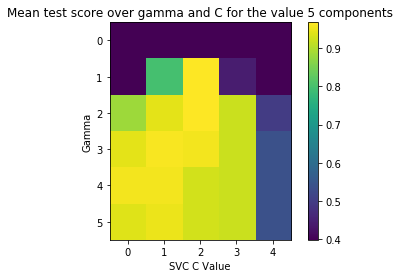

In [208]:
test_score = estimator.cv_results_['mean_test_score']
test_score.shape

n_nc = len(ncomp_test)
n_c = len(c_test)
n_gam = len(gam_test)

print([n_nc,n_c,n_gam])

test_score = test_score.reshape((n_nc,n_c,n_gam))
test_score.shape


# nc= nc_test[2]=5
plt.imshow(test_score[2,:,:])
plt.colorbar()
plt.xlabel('SVC C Value')
plt.ylabel('Gamma')
plt.title('Mean test score over gamma and C for the value 5 components')